In [1]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#import python packages for working with .cool, .bigwig and .gtf files
import cooler
import bioframe
import cooltools
import pyBigWig
from gtfparse import read_gtf

In [7]:
# import HiC map in .cool or .mcool 
# note: if you are importing .mcool file, you should specify the resolution
clr = cooler.Cooler('inputs/GSE130275_mESC_WT_combined_2.6B_chr1_3200.cool')
resolution = clr.binsize
print(resolution)

3200


In [4]:
# import gene annotation in .gft file to extract gene/transcript information
#df_gene0 = read_gtf("[pass to your .gtf file]/mm10.ensGene.gtf")
df_gene0 = read_gtf("inputs/mm10.ensGene_chr1.gtf")
df_gene0 = df_gene0[df_gene0['feature']=="transcript"]
df_gene0 = df_gene0[['seqname','start','end','strand','gene_id']]
df_gene0['length'] = df_gene0['end']-df_gene0['start']
df_gene0 = df_gene0.sort_values('length', ascending=False).drop_duplicates('gene_id')
df_gene0 = df_gene0.rename(columns = {'seqname': 'chrom'}, inplace = False)
df_gene0 = df_gene0.sort_values(['chrom','start'])
display(df_gene0)

/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
/Users/hsalari/opt/miniconda3/lib/python3.7/site-packages/gtfparse/read_gtf.py:154: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  features=features)
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_name', 'exon_number', 'exon_id']


,chrom,start,end,strand,gene_id,length
0,chr1,3073253,3074322,+,ENSMUSG00000102693,1069
2,chr1,3102016,3102125,+,ENSMUSG00000064842,109
10,chr1,3214482,3671498,-,ENSMUSG00000051951,457016
21,chr1,3252757,3253236,+,ENSMUSG00000102851,479
23,chr1,3365731,3368549,-,ENSMUSG00000103377,2818
...,...,...,...,...,...,...
109529,chr1,195220051,195222766,-,ENSMUSG00000102236,2715
109531,chr1,195228278,195228398,+,ENSMUSG00000093823,120
109533,chr1,195240910,195241007,-,ENSMUSG00000099208,97
109535,chr1,195259299,195259848,-,ENSMUSG00000104297,549


In [8]:
# select a subset of genes based on size
lmin = 10*resolution
lmax = 20*resolution
df_gene = df_gene0[(df_gene0['length']<lmax)&(df_gene0['length']>lmin)]
df_gene = df_gene.reset_index(drop=True)
display(df_gene)

,chrom,start,end,strand,gene_id,length
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513
...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962


In [9]:
# compute Intra-gene RNA Pol II (IR) score from PolII ChIP-seq data in BigWig format
#pol2 = pyBigWig.open("[pass to your .bigwig file]/GSM4173524_DMSO-N20-input_rep1.bw")
pol2 = pyBigWig.open("inputs/GSM4173524_DMSO-N20-input_rep1_chr1.bw")
l = len(df_gene)
for i in range(l):
    ch = df_gene.chrom[i]
    start = df_gene.start[i]
    end = df_gene.end[i]
    df_gene.loc[i,'IR_score'] = np.mean(pol2.values(ch,start,end))
df_gene.loc[:,'log2_IR_score'] = np.log2(df_gene['IR_score'])

display(df_gene)

,chrom,start,end,strand,gene_id,length,IR_score,log2_IR_score
0,chr1,3466587,3513553,+,ENSMUSG00000089699,46966,0.259446,-1.946495
1,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,3.726281,1.897736
2,chr1,4857814,4897905,+,ENSMUSG00000033813,40091,4.367942,2.126954
3,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.216582,0.282834
4,chr1,6359218,6394731,+,ENSMUSG00000087247,35513,0.303108,-1.722096
...,...,...,...,...,...,...,...,...
276,chr1,193221689,193264075,-,ENSMUSG00000016194,42386,0.397804,-1.329869
277,chr1,194976385,195027428,+,ENSMUSG00000096929,51043,0.495063,-1.014315
278,chr1,195041238,195092249,-,ENSMUSG00000016493,51011,0.389001,-1.362155
279,chr1,195097382,195131344,-,ENSMUSG00000016481,33962,1.248526,0.320226


In [11]:
# select genes based on IR scores
IRmin = 0
IRmax = 2
sub_df_gene = df_gene[(df_gene['log2_IR_score']<IRmax)&(df_gene['log2_IR_score']>IRmin)]
sub_df_gene = sub_df_gene.reset_index(drop=True)
display(sub_df_gene)

,chrom,start,end,strand,gene_id,length,IR_score,log2_IR_score
0,chr1,4807788,4848410,+,ENSMUSG00000025903,40622,3.726281,1.897736
1,chr1,6214645,6276648,+,ENSMUSG00000025907,62003,1.216582,0.282834
2,chr1,9548119,9580673,+,ENSMUSG00000025911,32554,1.370868,0.455090
3,chr1,9667415,9700209,-,ENSMUSG00000025912,32794,1.433969,0.520014
4,chr1,13623330,13660546,-,ENSMUSG00000025937,37216,3.473997,1.796596
...,...,...,...,...,...,...,...,...
79,chr1,189880492,189922363,-,ENSMUSG00000026603,41871,2.314339,1.210600
80,chr1,191170296,191218039,-,ENSMUSG00000026628,47743,1.035453,0.050262
81,chr1,191351975,191397041,-,ENSMUSG00000026626,45066,1.493477,0.578675
82,chr1,191575636,191623688,+,ENSMUSG00000037461,48052,3.022025,1.595515


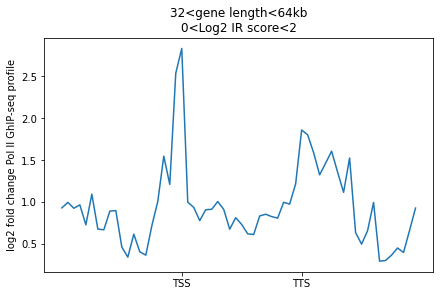

In [12]:
# pileup mtea-gene analysis (PMGA) of intra-gene Pol II ChIP-seq profile
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,4),constrained_layout = True)
start = sub_df_gene.start[0]-sub_df_gene.length[0]
end = sub_df_gene.end[0]+sub_df_gene.length[0]
ch = sub_df_gene.chrom[0]
snip = np.asarray(pol2.stats(ch,start,end, nBins=60))
stack = snip
l = len(sub_df_gene)
for i in range(1,l):
    start = sub_df_gene.start[i]-sub_df_gene.length[i]
    end = sub_df_gene.end[i]+sub_df_gene.length[i]
    ch = sub_df_gene.chrom[i]
    snip = np.asarray(pol2.stats(ch,start,end, nBins=60))
    stack = np.row_stack((stack,snip))
mask = np.array(sub_df_gene.strand == '-', dtype=bool)
stack[mask, :] = stack[mask, ::-1]
data = np.log2(np.nanmean(stack, axis=0))
ax.plot(np.arange(60),data)
ticks_pixels = [20,40]
ticks_labels = ['TSS','TTS']
ax.set_xticks(ticks_pixels)
ax.set_xticklabels(ticks_labels)
ax.set_ylabel('log2 fold change Pol II GhIP-seq profile')
ax.set_title(str(lmin//1000)+'<gene length<'+str(lmax//1000)+'kb\n'
          +str(IRmin)+'<Log2 IR score<'+str(IRmax))
np.savetxt('outputs/PMGA_ChIP_PolII.txt', data, fmt='%f')
fig.savefig("outputs/PMGA_ChIP_PolII.png")